In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

IMAGE_PATH = os.path.abspath(os.getcwd())
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(os.path.abspath(os.getcwd()), fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
from tf_agents.environments import suite_gym

env = suite_gym.load("SpaceInvaders-v4")
env

Saving figure invader-plot


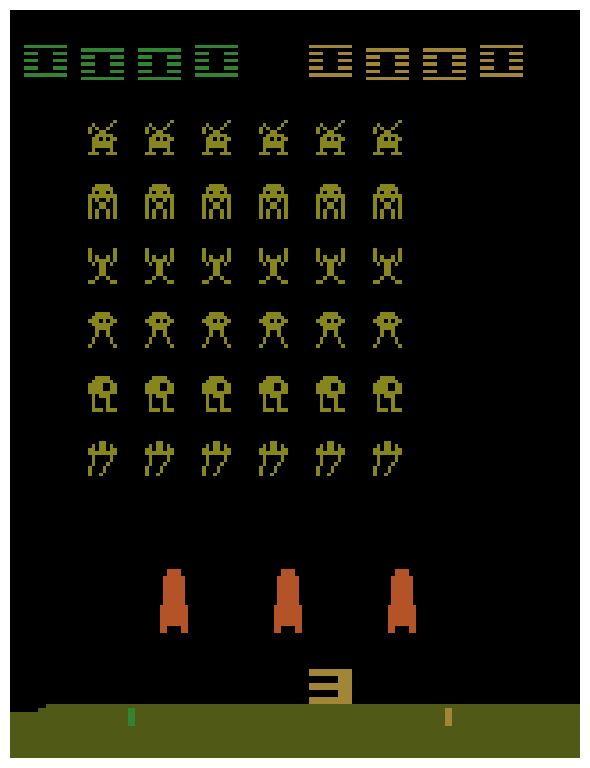

In [3]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("invader-plot")
plt.show()

In [6]:
from tf_agents.environments.wrappers import ActionRepeat
from tf_agents.environments.wrappers import TimeLimit
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

repeating_env = ActionRepeat(env, times=4)
# limited_repeating_env = suite_gym.load(
#     "SpaceInvaders-v4",
#     gym_env_wrappers=[lambda env: TimeLimit(env, max_episode_steps=10000)],
#     env_wrappers=[lambda env: ActionRepeat(env, times=4)]
# )
env = suite_gym.load(
    'SpaceInvaders-v4',
    max_episode_steps=27000,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4]
)

In [7]:
import numpy as np

def draw_obs(obs): #Draw the Observation Screen
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis('off')


Saving figure processed_invadar_game_pic


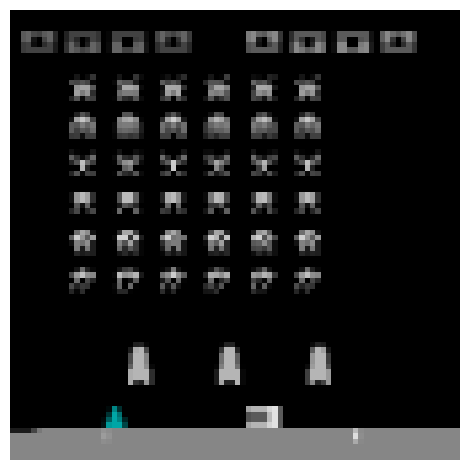

In [8]:
env.seed(32)

env.reset()
for _ in range(4): #Test control and get the trajectory
    time_step = env.step(3)

draw_obs(time_step.observation)
save_fig('processed_invadar_game_pic')
plt.show()

In [9]:
from tf_agents.environments import TFPyEnvironment
import keras
import tensorflow as tf
from tf_agents.networks.q_network import QNetwork

tf_env = TFPyEnvironment(env)

proprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.) #Default layer design from book
fc_layer_params = [512]
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
q_net = QNetwork(
    tf_env.observation_spec,
    tf_env.action_spec,
    preprocessing_layers=proprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)


AttributeError: 'function' object has no attribute 'shape'
  In call to configurable 'QNetwork' (<class 'tf_agents.networks.q_network.QNetwork'>)

In [ ]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_steps = tf.Variable(0)
update_period = 4
optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0)